In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralBiclustering
from sklearn.metrics import confusion_matrix, adjusted_rand_score
import pandas as pd

from plot import *
from tools import *

In [2]:
indiana_img = np.load('../data/indianapines.npy')
indiana_labels = np.load('../data/indianapines_gt.npy')
indiana_class_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill', 'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives', 'Stone-Steel-Towers']

salinas_img = np.load('../data/salinas.npy')
salinas_labels = np.load('../data/salinas_gt.npy')
salinas_class_names = ['Brocoli_green_weeds_1', 'Brocoli_green_weeds_2', 'Fallow', 'Fallow_rough_plow', 'Fallow_smooth', 'Stubble', 'Celery', 'Grapes_untrained', 'Soil_vinyard_develop', 'Corn_senesced_green_weeds', 'Lettuce_romaine_4wk', 'Lettuce_romaine_5wk', 'Lettuce_romaine_6wk', 'Lettuce_romaine_7wk', 'Vinyard_untrained', 'Vinyard_vertical_trellis']

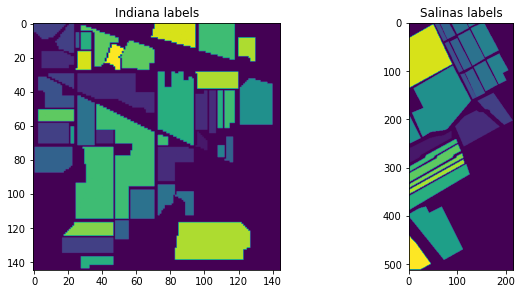

In [3]:
plot_two_figures(indiana_labels, salinas_labels, "Indiana labels", "Salinas labels")

In [4]:
# normalize radiance values to get reflectance values
indiana_img = indiana_img / indiana_img.max()
salinas_img = salinas_img / salinas_img.max()

In [5]:
print("Indiana shape: {}".format(indiana_img.shape))
print("Salinas shape: {}".format(salinas_img.shape))

Indiana shape: (145, 145, 200)
Salinas shape: (512, 217, 204)


In [6]:
X_indiana = indiana_img.reshape((-1, indiana_img.shape[-1])) # reshaping the HSI as a 2D matrix
print("Indiana shape: {}".format(X_indiana.shape))

X_salinas = salinas_img.reshape((-1, salinas_img.shape[-1])) # reshaping the HSI as a 2D matrix
print("Salinas shape: {}".format(X_salinas.shape))

Indiana shape: (21025, 200)
Salinas shape: (111104, 204)


In [7]:
def get_number_components(X):
    # first PCA with by keeping all features
    print("Fitting the PCA")
    pca_model = PCA()
    pca_model.fit(X)
    var_cumsum = pca_model.explained_variance_ratio_.cumsum()
    return len(var_cumsum[var_cumsum <= 0.9991])

def extract_features(X, n_components):
    pca_model = PCA(n_components=n_components)
    pca_model.fit(X)
    return pca_model.transform(X)

In [8]:
n_components_indiana = get_number_components(X_indiana)
n_components_salinas = get_number_components(X_salinas)

Fitting the PCA
Fitting the PCA


In [9]:
print("Number of components Indiana: {}".format(n_components_indiana))
print("Number of components Salinas: {}".format(n_components_salinas))

Number of components Indiana: 69
Number of components Salinas: 6


In [10]:
X_indiana_reduced = extract_features(X_indiana, n_components_indiana)
X_salinas_reduced = extract_features(X_salinas, 20)

In [11]:
print("Indiana reduced data shape: {}".format(X_indiana_reduced.shape))
print("Salinas reduced data shape: {}".format(X_salinas_reduced.shape))

Indiana reduced data shape: (21025, 69)
Salinas reduced data shape: (111104, 20)


In [12]:
n_cluster_indiana = len(np.unique(indiana_labels)) - 1
n_cluster_salinas = len(np.unique(salinas_labels)) - 1

In [13]:
print("Number of labels Indiana: {}".format(n_cluster_indiana))
print("Number of labels Salinas: {}".format(n_cluster_salinas))

Number of labels Indiana: 16
Number of labels Salinas: 16


## Spectral Biclustering indiana

In [14]:
indiana_model = SpectralBiclustering(n_clusters=n_cluster_indiana)

In [15]:
indiana_model.fit(X_indiana_reduced)

SpectralBiclustering(n_clusters=16)

In [16]:
indiana_model.row_labels_.shape, indiana_model.column_labels_.shape

((21025,), (69,))

In [17]:
indiana_preds = indiana_model.row_labels_
indiana_preds = indiana_preds.reshape((indiana_img.shape[0], indiana_img.shape[1]))
indiana_preds.shape

(145, 145)

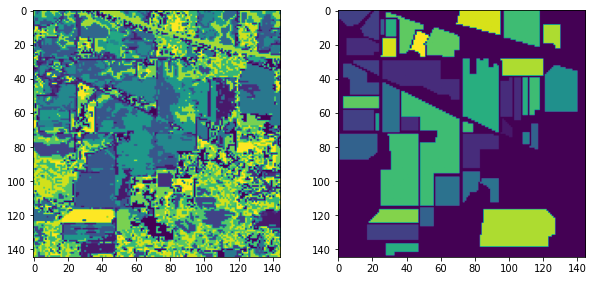

In [18]:
plot_two_figures(indiana_preds, indiana_labels)

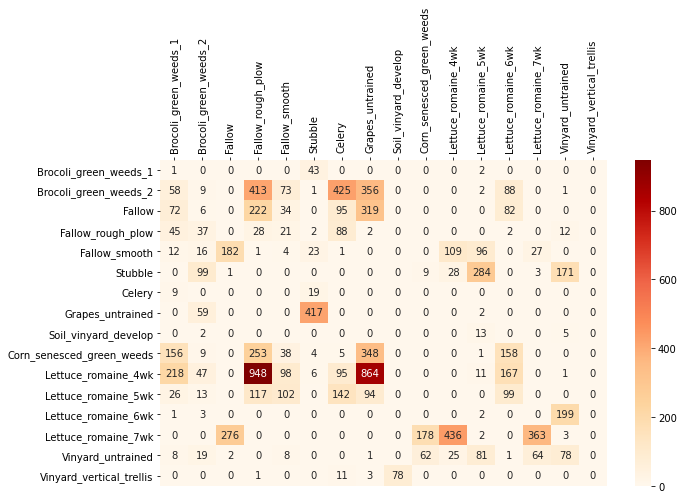

In [19]:
plot_confusion_matrix(indiana_labels, indiana_preds, salinas_class_names)

## Spectral Biclustering Salinas

In [20]:
model_salinas = SpectralBiclustering(n_clusters=n_cluster_salinas)

In [21]:
model_salinas.fit(X_salinas_reduced)

SpectralBiclustering(n_clusters=16)

In [22]:
salinas_preds = model_salinas.row_labels_.reshape((salinas_img.shape[0], salinas_img.shape[1]))

In [23]:
salinas_preds_corrected = remove_unclassified(salinas_preds, salinas_labels)

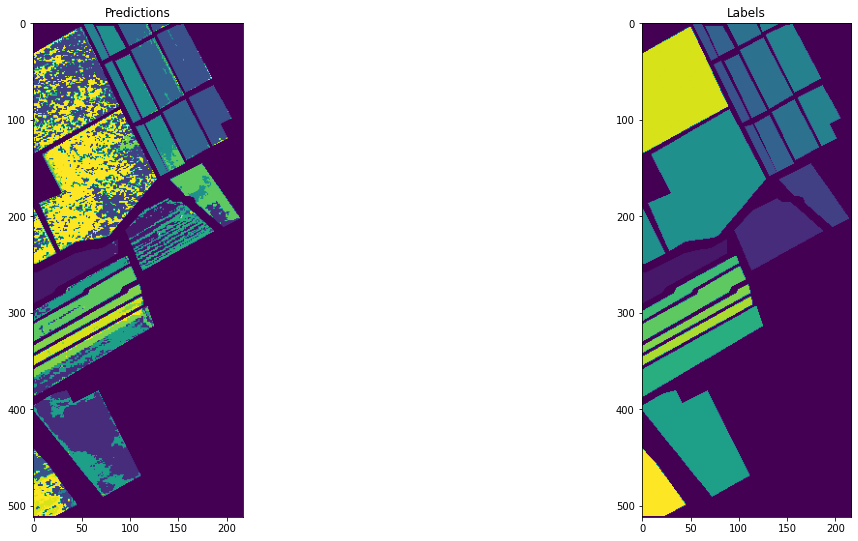

In [24]:
plot_two_figures(salinas_preds_corrected, salinas_labels, 'Predictions', 'Labels', figsize=(20, 20))

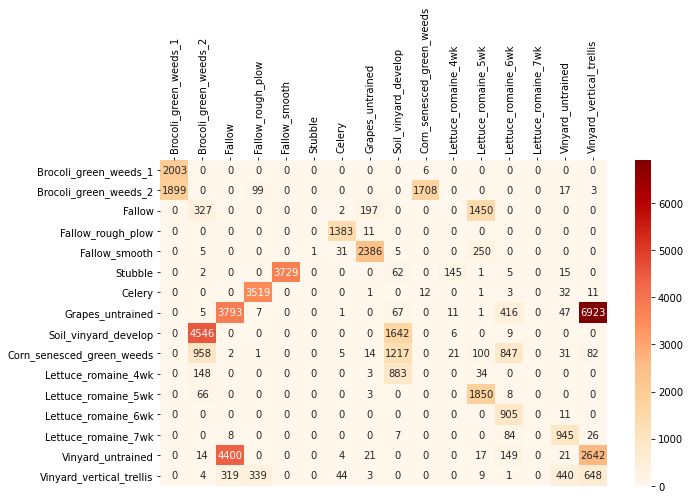

In [25]:
plot_confusion_matrix(salinas_labels, salinas_preds_corrected, salinas_class_names)

In [26]:
salinas_labels_cpy, final_preds = compute_labels_correspondence(salinas_labels, salinas_preds_corrected, n_cluster_salinas)

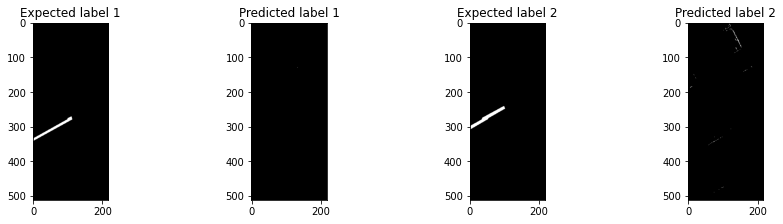

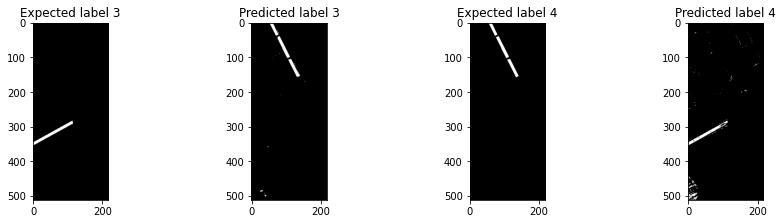

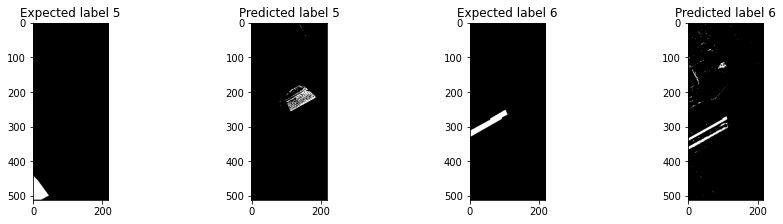

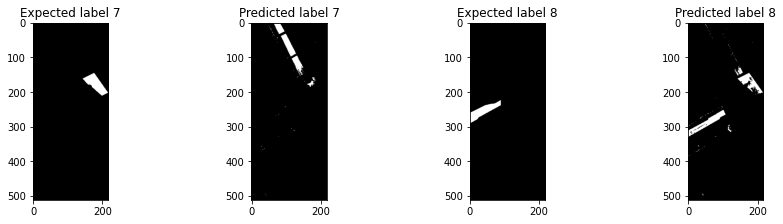

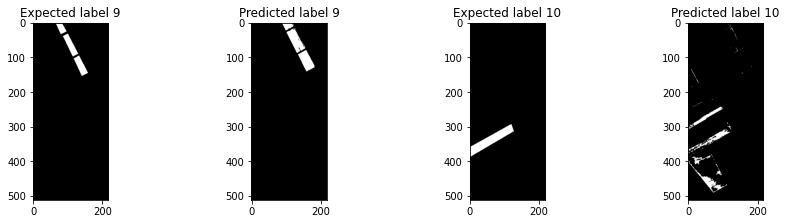

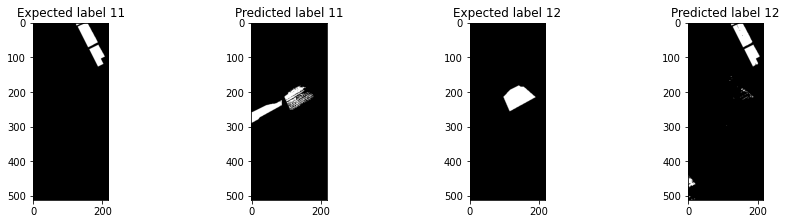

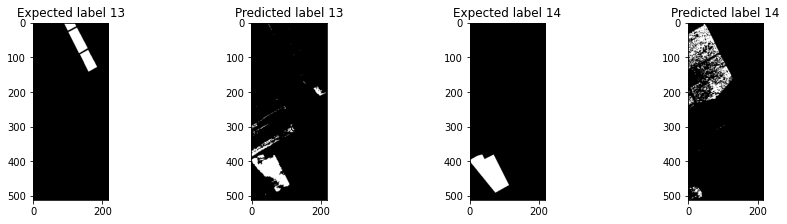

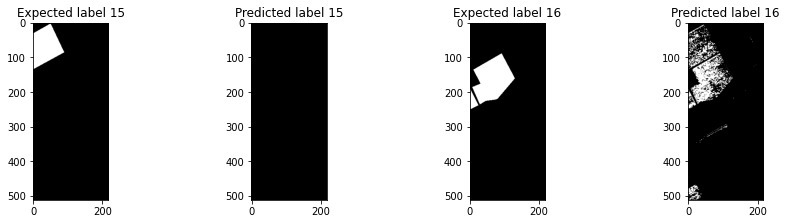

In [27]:
plot_each_labels(salinas_labels_cpy, final_preds, n_cluster_salinas, figsize=(15, 15), cmap='gray')

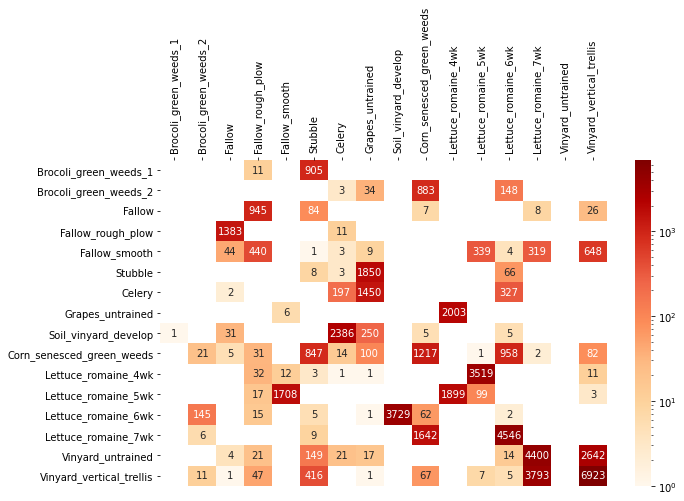

In [28]:
plot_confusion_matrix(salinas_labels_cpy, final_preds, salinas_class_names, log=True)

In [29]:
salinas_labels_flatten = salinas_labels.flatten()
final_preds_flatten = final_preds.flatten()

test = salinas_labels_flatten[~(salinas_labels_flatten==0)]
test2 = final_preds_flatten[~(final_preds_flatten==0)]

adjusted_rand_score(test, test2)

0.5028948468962897